In [1]:
# velovi environment
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
adata = scv.datasets.pancreas()

100%|██████████| 50.0M/50.0M [00:07<00:00, 7.01MB/s]


In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

# see https://github.com/theislab/scvelo/issues/1212
# scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 65 genes that are detected 30 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.


/opt/miniconda3/envs/velovi/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [7]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 489/500:  98%|█████████▊| 489/500 [23:33<00:31,  2.89s/it, v_num=1, train_loss_step=-2.31e+3, train_loss_epoch=-2.34e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2253.596. Signaling Trainer to stop.


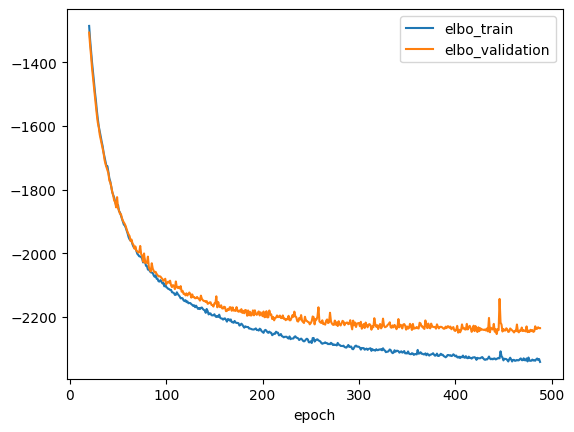

In [8]:
fig, ax = plt.subplots()
vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()

In [10]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling

    # I got an error of "ValueError: Multi-dimensional indexing (e.g. obj[:, None]) is no longer supported"
    # adata.var["fit_t_"] = (
    #     torch.nn.functional.softplus(vae.module.switch_time_unconstr)
    #     .detach()
    #     .cpu()
    #     .numpy()
    # ) * scaling
    # adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    # adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

In [11]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/12 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/opt/miniconda3/envs/velovi/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/velovi/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/velovi/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/velovi/lib/python3.9/site-packages/scvelo/plotting/utils.py:6

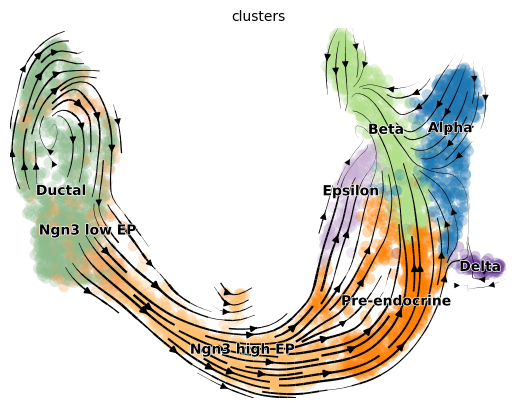

In [12]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

Intrinsic uncertainty

In [13]:
uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=100)
uncertainty_df.head()

INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2328 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    9.8s finished


,directional_variance,directional_difference,directional_cosine_sim_variance,directional_cosine_sim_difference,directional_cosine_sim_mean
index,,,,,
AAACCTGAGAGGGATA,0.001106,0.102416,0.000643,0.078207,0.648207
AAACCTGAGCCTTGAT,0.001376,0.134981,0.000853,0.106649,0.618533
AAACCTGAGGCAATTA,0.001186,0.118515,0.000692,0.090431,0.650950
AAACCTGCATCATCCC,0.001686,0.127795,0.000972,0.097047,0.648648
AAACCTGGTAAGTGGC,0.001025,0.104935,0.000571,0.078587,0.661756


In [14]:
for c in uncertainty_df.columns:
    adata.obs[c] = np.log10(uncertainty_df[c].values)

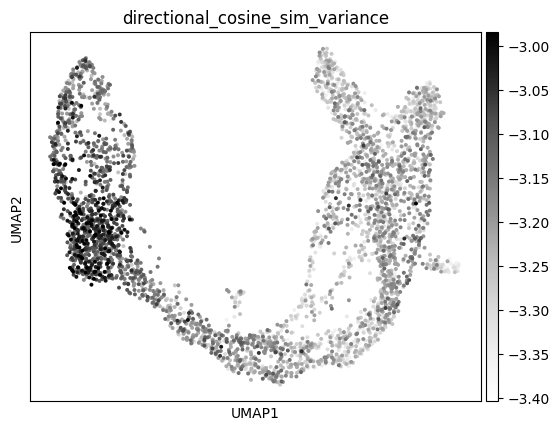

In [15]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance",
    cmap="Greys",
    vmin="p1",
    vmax="p99",
)

Extrinsic uncertainty

In [16]:
def compute_extrinisic_uncertainty(adata, vae, n_samples=25) -> pd.DataFrame:
    from velovi._model import _compute_directional_statistics_tensor
    from scvi.utils import track
    from contextlib import redirect_stdout
    import io

    extrapolated_cells_list = []
    for i in track(range(n_samples)):
        with io.StringIO() as buf, redirect_stdout(buf):
            vkey = "velocities_velovi_{i}".format(i=i)
            v = vae.get_velocity(n_samples=1, velo_statistic="mean")
            adata.layers[vkey] = v
            scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=False, approx=True)
            t_mat = scv.utils.get_transition_matrix(
                adata, vkey=vkey, self_transitions=True, use_negative_cosines=True
            )
            extrapolated_cells = np.asarray(t_mat @ adata.layers["Ms"])
            extrapolated_cells_list.append(extrapolated_cells)
    extrapolated_cells = np.stack(extrapolated_cells_list)
    df = _compute_directional_statistics_tensor(extrapolated_cells, n_jobs=-1, n_cells=adata.n_obs)
    return df

In [17]:
ext_uncertainty_df = compute_extrinisic_uncertainty(adata, vae)

Working...: 100%|██████████| 25/25 [01:12<00:00,  2.88s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3673 out of 3696 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    1.1s finished


In [23]:
# Fixing a bug about the columns
df = ext_uncertainty_df[0]

In [25]:
for c in df.columns:
    adata.obs[c + "_extrinisic"] = np.log10(df[c].values)

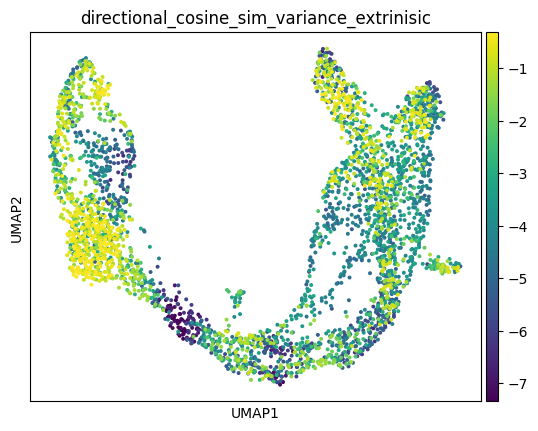

In [26]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance_extrinisic",
    vmin="p1", 
    vmax="p99", 
)

Making sure we get velocity vectors

In [27]:
velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

In [28]:
velocities.shape

(3696, 1026)

In [30]:
type(velocities)

pandas.core.frame.DataFrame

In [31]:
velocities

index,Sntg1,Sbspon,Mcm3,Fam135a,Adgrb3,Uggt1,Tbc1d8,Fhl2,Slc39a10,Pgap1,...,Pak3,Zcchc16,Wnk3,Rragb,Sh3kbp1,Map3k15,Rai2,Ap1s2,Tmem27,Eif2s3y
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAGGGATA,0.014189,0.003953,0.000427,-0.080006,0.015943,-0.035287,-0.021420,0.064619,-0.088977,0.007646,...,0.061733,-0.000000,0.020297,-0.002278,-0.050835,-0.014864,-0.076124,0.019145,0.040030,-0.003865
AAACCTGAGCCTTGAT,0.001573,-0.026462,-0.046127,-0.050018,0.000354,-0.002611,-0.008486,0.000045,-0.043439,0.084531,...,0.016476,-0.000000,-0.003046,0.003842,0.033167,0.000835,0.000740,-0.000000,0.002508,0.001012
AAACCTGAGGCAATTA,0.005978,0.003786,0.000712,-0.088930,-0.025640,-0.009452,0.001213,0.037232,-0.070225,-0.006812,...,0.123315,-0.000444,-0.004030,-0.011768,0.011454,0.001357,-0.078258,-0.040149,0.007127,-0.023528
AAACCTGCATCATCCC,0.001652,0.005666,-0.063284,0.025499,-0.000000,-0.006548,0.007189,0.029892,-0.071368,0.028527,...,0.009630,-0.000000,0.009077,0.034568,0.012926,0.000417,-0.000000,-0.000000,0.019415,0.028636
AAACCTGGTAAGTGGC,0.002232,0.012049,-0.002292,-0.022786,0.052811,0.022376,-0.047524,0.046388,0.004167,0.024405,...,0.104019,0.001282,-0.002489,-0.000000,0.048524,-0.077496,-0.000000,0.000379,0.001742,-0.009257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTGACATA,0.008088,0.002884,-0.000249,-0.049639,-0.010577,0.018296,-0.014224,0.062742,-0.055687,-0.027579,...,0.075581,-0.009940,0.014835,-0.000000,0.010176,-0.046502,-0.042754,0.010423,0.020303,0.020299
TTTGTCAAGTGTGGCA,0.002233,0.000162,-0.020865,-0.018739,0.079913,-0.006309,-0.015628,0.033836,-0.011008,0.007232,...,0.003994,0.002663,0.012563,0.003831,0.105012,0.068380,0.000467,-0.004560,0.003222,-0.004542
TTTGTCAGTTGTTTGG,0.001792,-0.029368,0.029408,0.015469,0.000853,-0.006323,-0.000000,0.001796,-0.039956,0.055540,...,-0.001568,-0.000000,-0.000990,-0.000000,0.003813,-0.001287,0.000905,-0.000000,0.005689,0.031721
